In [2]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import root_mean_squared_error


# Carga y Preparación de data

In [3]:
consumo = pd.read_excel("CONSUMO-2024-06.xlsx", skiprows = 6)
importacion = pd.read_excel("IMPORTACION-VOLUMEN-2024-06.xlsx", skiprows = 6)
precios2024 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2024", skiprows = 9, header = None, 
                        names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2023 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2023", skiprows = 9, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2022 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2022", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2021 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2021", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])

In [4]:
precios2024.drop(precios2024.tail(9).index, inplace = True)
precios2023.drop(precios2023.tail(2).index, inplace = True)
precios2022.drop(precios2022.tail(2).index, inplace = True)
precios2021.drop(precios2021.tail(2).index, inplace = True)

In [5]:
precios = pd.concat([precios2021, precios2022, precios2023, precios2024], ignore_index = True)

In [6]:
#Se suman los consumos de Diesel, ya que de 2000 a 2018 se consumía alto en azufre y a partir de enero 2018 se consumía bajo en azufre
consumo["Diesel"] = consumo["Diesel bajo azufre"]+consumo["Diesel alto azufre"]
importacion["Diesel"] = importacion["Diesel bajo azufre"]+importacion["Diesel alto azufre"]

In [7]:
consumo = consumo[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
importacion = importacion[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
precios = precios[["Fecha", "Diesel", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", "Regular", "Superior"]].copy()

In [8]:
consumo.drop(consumo.tail(3).index, inplace = True)
importacion.drop(importacion.tail(3).index, inplace = True)

In [9]:
consumo["Fecha"] = pd.to_datetime(consumo["Fecha"])
importacion["Fecha"] = pd.to_datetime(importacion["Fecha"])
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

# Modelos LSTM

In [10]:
tf.random.set_seed(1122)

## Consumo Gasolina Regular

In [11]:
regular = consumo[["Fecha", "Gasolina regular"]].copy()
regular.set_index("Fecha", inplace = True)
regular.head()


,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34


In [12]:
print("Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular")
regularTest = adfuller(regular, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular
Estadístico de prueba          2.430669
p-value                        0.999024
# de retardos usados          14.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El valor-p de la prueba ADF confirma que no es una serie de tiempo estacionaria en media. Por lo tanto, es necesario diferenciarla.

In [13]:
print("Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular")
regular_diff = regular.diff()
regular_diff.fillna(0,inplace = True)
regularTest = adfuller(regular_diff, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular
Estadístico de prueba         -4.316925
p-value                        0.000415
# de retardos usados          16.000000
# de observaciones usadas    277.000000
Critical Value (1%)           -3.454180
Critical Value (5%)           -2.872031
Critical Value (10%)          -2.572360
dtype: float64


El valor-p confirma que con una diferenciación es suficiente para que la serie de tiempo sea estacionaria en media.

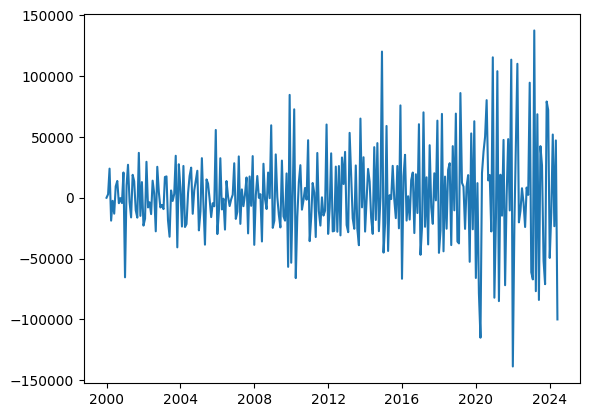

In [14]:
plt.plot(regular_diff)

In [15]:
scaler = StandardScaler()
regular_diff_scaled = scaler.fit_transform(regular_diff)

### Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [16]:
num_separacion = consumo.index[consumo["Fecha"]==pd.to_datetime("2021-12")][0]
num_val = int(len(regular_diff_scaled)*0.1)
train = regular_diff_scaled[:num_separacion-num_val]
validation = regular_diff_scaled[num_separacion-num_val:num_separacion]
test = regular_diff_scaled[num_separacion:]
#train = regular_diff[:num_separacion]
#test = regular_diff[num_separacion:]

In [17]:
def df_a_X_y(df,retrasos = 1):
    if type(df) is pd.DataFrame:
        df_as_np = df.to_numpy()
    else:
        df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-retrasos):
        row = [a for a in df_as_np[i:(i+retrasos)]]
        X.append(row)
        label = df_as_np[i+retrasos][0]
        y.append(label)
        
    return np.array(X), np.array(y)


retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [18]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [20]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.4103 - val_loss: 2.1276
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3907 - val_loss: 2.0982
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3820 - val_loss: 2.0787
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3758 - val_loss: 2.0628
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3713 - val_loss: 2.0507
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3680 - val_loss: 2.0401
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3657 - val_loss: 2.0306
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3642 - val_loss: 2.0216
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3633 - val_loss: 2.0141
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3626 - val_loss: 2.0079
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3622 - val_loss: 2.0022
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3616 - val_loss: 1.9978
Ep

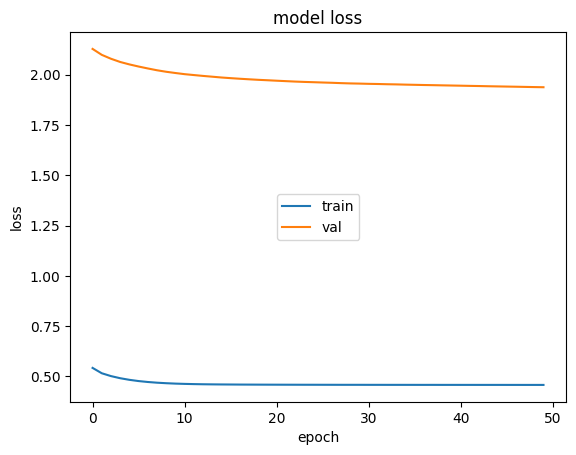

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [22]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3615 
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.9373
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.2735


2.273503303527832

In [23]:
def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1, retrasos = 1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+retrasos-1+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

In [24]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion-num_val, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion, retrasos = retrasos)

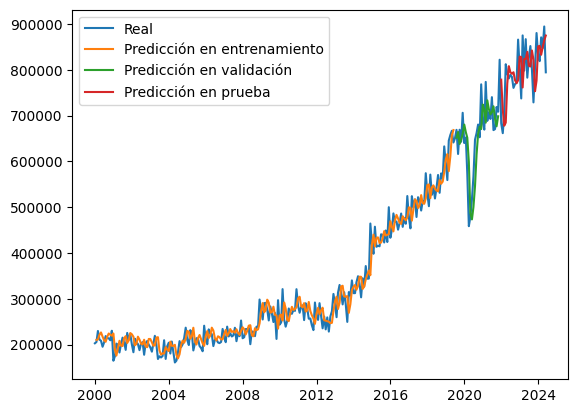

In [25]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = regular[1:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = regular[num_separacion-num_val+1:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = regular[num_separacion+1:].index)

plt.plot(regular, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

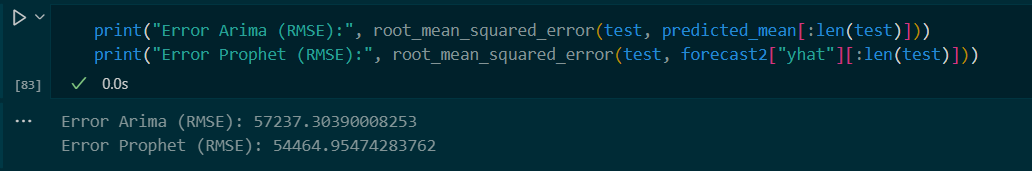

In [26]:
from IPython.display import Image
Image("C:/Users/PMarr/Documents/Documents/GitHub/lab03DS/ErroresRegular.png")

Error del primer LSTM:

In [27]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(regular[num_separacion+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 58658.889119435386


### Creación segundo modelo

In [28]:
retrasos = 2
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

modelo2 = Sequential()

modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(16, 'relu'))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,081 (70.63 KB)

 Trainable params: 18,081 (70.63 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [30]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.4205 - val_loss: 2.2580
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3905 - val_loss: 2.2313
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3771 - val_loss: 2.2087
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3676 - val_loss: 2.1883
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3601 - val_loss: 2.1687
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3537 - val_loss: 2.1520
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3479 - val_loss: 2.1336
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3426 - val_loss: 2.1171
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3379 - val_loss: 2.1030
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3333 - val_loss: 2.0885
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3287 - val_loss: 2.0743
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3244 - val_loss

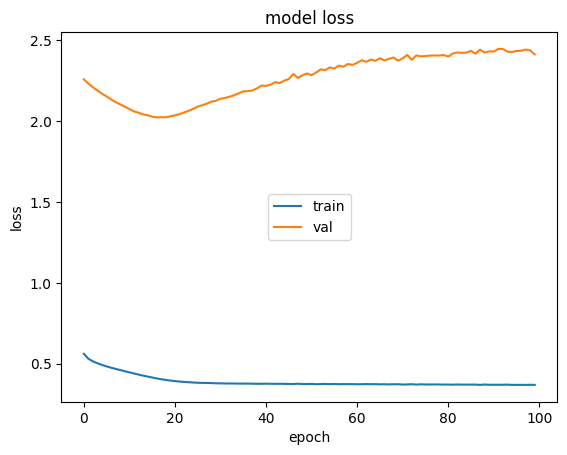

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [32]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3149 
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.4116
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.8995


1.8994736671447754

In [33]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion-num_val, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion, retrasos = retrasos)

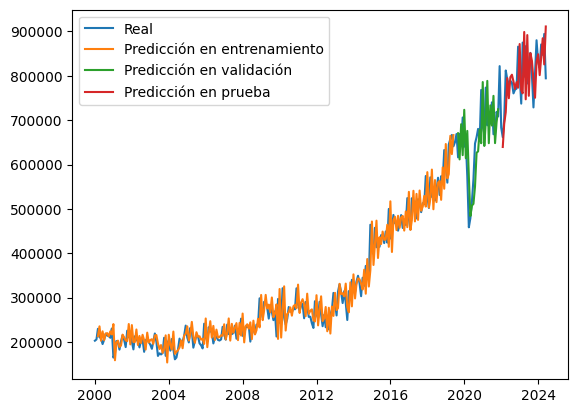

In [34]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = regular[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = regular[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = regular[num_separacion+retrasos:].index)

plt.plot(regular, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Error del segundo LSTM:

In [35]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(regular[num_separacion+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 62165.599771366105


## Importación Diesel

In [36]:
diesel = importacion[['Fecha', 'Diesel']].copy()
diesel.set_index('Fecha', inplace = True)

train_size = int(len(diesel) * 0.8)
train_diesel = diesel[0:train_size]
test_diesel = diesel[train_size:len(diesel)]

ts_diesel = train_diesel['Diesel']

## Precio de Gasolina Superior

In [37]:
superior = precios[["Fecha", "Superior"]].copy()
superior.set_index("Fecha", inplace = True)
superior.head()


,Superior
Fecha,
2021-01-01,21.91
2021-01-02,21.91
2021-01-03,21.91
2021-01-04,21.91
2021-01-05,21.91


In [38]:
print("Prueba de Dickey-Fuller para la serie de tiempo del precio de gasolina superior")
superiorTest = adfuller(superior, autolag = "AIC")
salidaDf = pd.Series(superiorTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in superiorTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo del precio de gasolina superior
Estadístico de prueba          -2.963637
p-value                         0.038433
# de retardos usados            7.000000
# de observaciones usadas    1318.000000
Critical Value (1%)            -3.435321
Critical Value (5%)            -2.863735
Critical Value (10%)           -2.567939
dtype: float64


El valor-p de la prueba ADF confirma que es una serie de tiempo estacionaria en media. Por lo tanto, no es necesario diferenciarla.

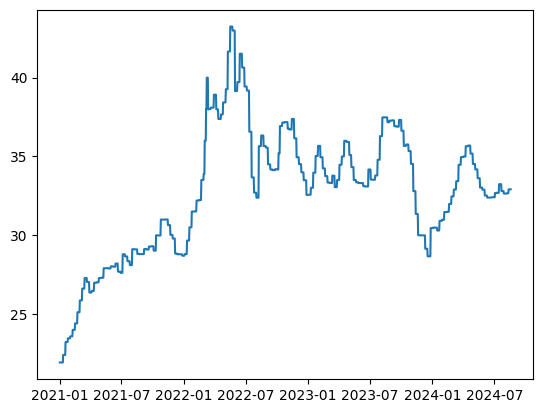

In [39]:
plt.plot(superior)

In [40]:
scaler3 = StandardScaler()
superior_scaled = scaler3.fit_transform(superior)

### Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [41]:
num_separacion = precios.index[precios["Fecha"]==pd.to_datetime("2023-12-31")][0]
num_val = int(len(superior_scaled)*0.1)
train = superior_scaled[:num_separacion-num_val]
validation = superior_scaled[num_separacion-num_val:num_separacion]
test = superior_scaled[num_separacion:]

In [44]:
retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [47]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [49]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1215 - val_loss: 0.6545
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9179 - val_loss: 0.5955
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7471 - val_loss: 0.5179
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4997 - val_loss: 0.4345
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2619 - val_loss: 0.3465
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0259 - val_loss: 0.2576
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7976 - val_loss: 0.1735
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5862 - val_loss: 0.1014
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4014 - val_loss: 0.0484
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2540 - val_loss: 0.0194
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1525 - val_loss: 0.0118
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0963 - val_lo

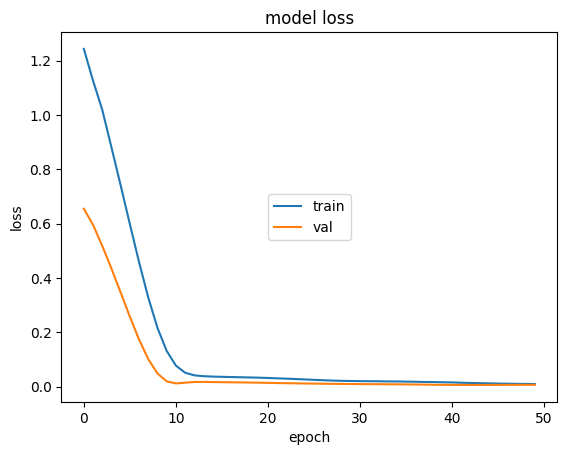

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [51]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088 
Pérdida en Validación
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.0048   
Pérdida en Prueba
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016     


0.0016132585005834699

In [52]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler3,dif=False)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler3,dif=False)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler3,dif=False)

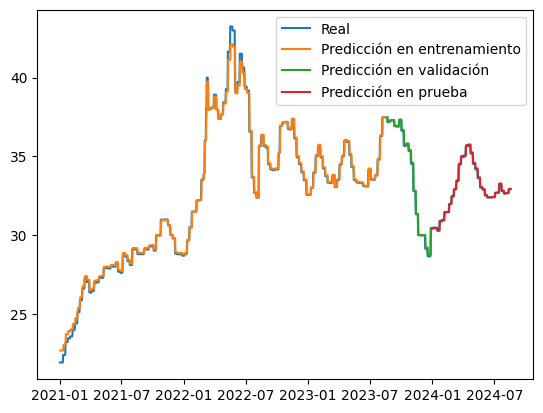

In [54]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = superior[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = superior[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = superior[num_separacion+retrasos:].index)

plt.plot(superior, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

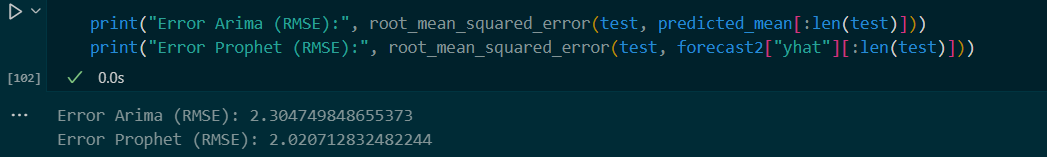

In [57]:
Image("C:/Users/PMarr/Documents/Documents/GitHub/lab03DS/ErroresSuperior.png")

Error del primer LSTM:

In [56]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(superior[num_separacion+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 0.1639878587772774


### Creación segundo modelo

In [69]:
retrasos = 7
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

modelo2 = Sequential()

modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [71]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6908 - val_loss: 0.2263
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9000 - val_loss: 0.0434
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3764 - val_loss: 0.0222
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1711 - val_loss: 0.0220
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1318 - val_loss: 0.0224
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1031 - val_loss: 0.0230
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0819 - val_loss: 0.0235
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0662 - val_loss: 0.0241
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0553 - val_loss: 0.0247
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0480 - val_loss: 0.0248
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0433 - val_loss: 0.0247
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

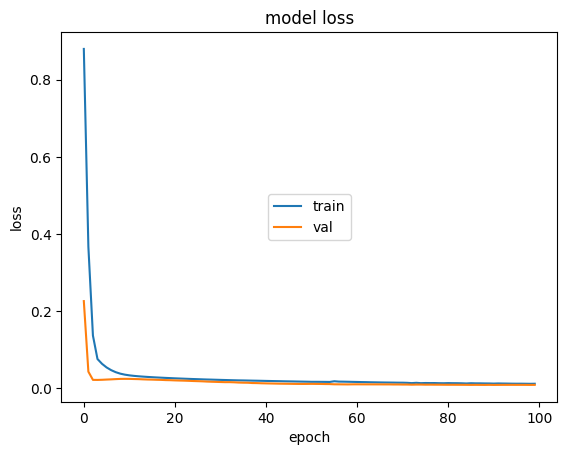

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [73]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 
Pérdida en Validación
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 
Pérdida en Prueba
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 


0.0035907141864299774

In [74]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler3,dif=False)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler3,dif=False)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler3,dif=False)

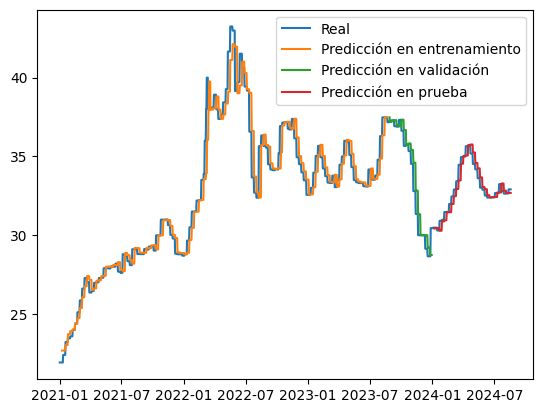

In [75]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = superior[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = superior[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = superior[num_separacion+retrasos:].index)

plt.plot(superior, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Error del segundo LSTM:

In [76]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(superior[num_separacion+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 0.42715508497006327
